In [15]:
# import zipfile
# with zipfile.ZipFile('/notebooks/ai-vs-human-generated-dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('/notebooks')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from math import sqrt

In [17]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

# print("Path to dataset files:", path)

In [2]:
path = 'train.csv'
train_df = pd.read_csv(path)
file_paths = train_df['file_name'].to_numpy()
Labels = train_df['label'].to_numpy()
train_df.shape

(79950, 3)

In [3]:
path = 'test.csv'
test_df = pd.read_csv(path)
test_df.shape

(5540, 1)

In [4]:
def show_image(image, label):
    # image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.show()

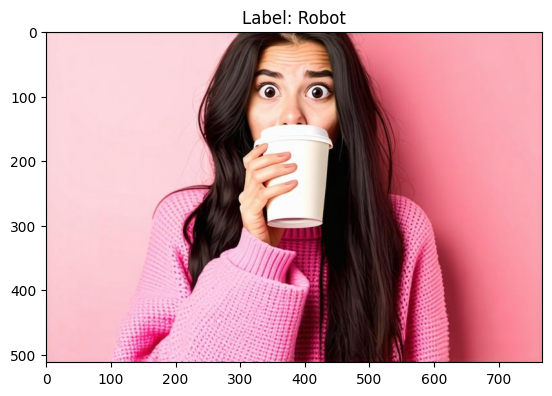

In [6]:
import random
index = np.random.randint(len(file_paths))

img = plt.imread(f'{file_paths[index]}')
label = 'Robot' if Labels[index] == 1 else "Human"
show_image(img, label)

In [7]:
# ones = 0
# zeros = 0
# for label in Labels:
#     if label == 0:
#         zeros += 1
#     else:
#         ones += 1

# counts, bins = np.histogram(Labels)
# plt.stairs(counts, bins)
# plt.show()
# print(f'Fake:{ones}', f'Orginal:{zeros}')

In [8]:
# import cv2

# resolution = {}

# for img, label in zip(file_paths, Labels):
#     img = cv2.imread(f'/kaggle/input/ai-vs-human-generated-dataset/{img}')
#     height = img.shape[0]
#     width = img.shape[1]
#     res = (height, width)
#     if res not in resolution.keys():
#         resolution[res] = 1
#     else:
#         resolution[res] += 1

In [9]:
class Params:
    def __init__(self):
        self.batch_size = 32
        self.name = "resnet101"
        self.lr = 0.1
        self.workers = 2
        self.moment = 0.9 
        self.weight_decay = 1e-4
        self.lr_step_size = 30
        self.lr_gamma = 0.1
        self.total_epochs = 500

    def __repr__(self):
        return str(self.__dict__)
    
    def __eq__(self, other):
        return self.__dict__ == other.__dict__

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

params = Params()
params, params.batch_size

Using cuda device


({'batch_size': 32, 'name': 'resnet101', 'lr': 0.1, 'workers': 2, 'moment': 0.9, 'weight_decay': 0.0001, 'lr_step_size': 30, 'lr_gamma': 0.1, 'total_epochs': 500},
 32)

In [10]:
X_ = train_df['file_name']
y = train_df['label']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.20, random_state=42, stratify=train_df['label'])

print("Train Set Shape:", X_train.shape, y_train.shape)
print("Test Set Shape:", X_test.shape, y_test.shape)

Train Set Shape: (63960,) (63960,)
Test Set Shape: (15990,) (15990,)


In [12]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, root_dir, labels, mode = 'train'):
        self.dataframe = df
        self.root_dir = root_dir
        self.labels = labels
        if mode == 'train':
            self.transform  = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe[idx])
        image = Image.open(img_name) 
        image = image.convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]

        return image, label

In [13]:
train_dataset = CustomDataset(X_train.to_numpy(),'',  y_train.to_numpy(), 'train')
val_dataset = CustomDataset(X_test.to_numpy(), '', y_test.to_numpy(), 'val')

In [14]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=params.batch_size,
    sampler=train_sampler,
    num_workers = params.workers,
    pin_memory=True
)

In [15]:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=params.workers,
    shuffle=False,
    pin_memory=True
)

In [16]:
def train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    model.train()
    start0 = time.time()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        y = y.unsqueeze(1).float()
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        batch_size = len(X)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}], {(current/size * 100):>4f}%")
            step=epoch+current/size
            writer.add_scalar('training loss', 
                            loss,
                            step)
            new_start = time.time()
            delta = new_start - start
            start = new_start
            if batch != 0:
                print("Done in ", delta, " seconds")
                remaining_steps = size - current
                speed = 100 * batch_size / delta
                remaining_time = remaining_steps / speed
                print("Remaining time (seconds): ", remaining_time)
        optimizer.zero_grad()
    print("Entire epoch done in ", time.time() - start0, " seconds")

In [17]:
def test(dataloader, model, loss_fn, epoch, writer, train_dataloader, calc_acc5=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, correct_top5 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.unsqueeze(1).float()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predicted = (torch.sigmoid(pred) >= 0.5).float()
            test_loss += loss_fn(pred, y).item()
            correct += (predicted == y).sum().item()
            if calc_acc5:
                _, pred_top5 = pred.topk(5, 1, largest=True, sorted=True)
                correct_top5 += pred_top5.eq(y.view(-1, 1).expand_as(pred_top5)).sum().item()
    test_loss /= num_batches
    step = epoch
    if writer != None:
        writer.add_scalar('test loss',
                            test_loss,
                            step)
    correct /= size
    correct_top5 /= size
    if writer != None:
        writer.add_scalar('test accuracy',
                            100*correct,
                            step)
        if calc_acc5:
            writer.add_scalar('test accuracy5',
                            100*correct_top5,
                            step)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if calc_acc5:
        print(f"Test Error: \n Accuracy-5: {(100*correct_top5):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [18]:
model = torchvision.models.resnet101(pretrained=True)
model.fc=nn.Linear(model.fc.in_features, 1)
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = params.lr, momentum=params.moment, weight_decay = params.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params.lr_step_size, gamma=params.lr_gamma)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 292MB/s] 


In [19]:
torch.cuda.empty_cache()
model = model.to(device)
resume_training = True

In [20]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

start_dataset_idx = 1
start_epoch = 1
early_stopping_patience = 50
no_improvement_count = 0
best_val_accuracy = float('-inf')

checkpoint_path = os.path.join("checkpoints", params.name, f"checkpoint.pth")

if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_accuracy = checkpoint.get("best_val_accuracy", float('-inf')) 
    no_improvement_count = checkpoint.get("no_improvement_count", 0)
    assert params == checkpoint["params"]

Path(os.path.join("checkpoints", params.name)).mkdir(parents=True, exist_ok=True)
writer = SummaryWriter('runs/' + params.name)

2025-01-26 08:55:58.804013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 08:55:58.804064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 08:55:58.804941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 08:55:58.810273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 08:55:59.733001: W tensorflow/compiler/tf2

In [21]:
print(start_epoch)
print(best_val_accuracy)

57
0.9864915572232645


In [ ]:
for epoch in range(start_epoch, params.total_epochs):
    train(train_loader, model, loss_fn, optimizer, epoch, writer)
    val_accuracy = test(val_loader, model, loss_fn, epoch, writer, train_dataloader=train_loader, calc_acc5=False)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_count = 0
        
        checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
        "params": params,
        "best_val_accuracy": best_val_accuracy,
        "no_improvement_count": no_improvement_count,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint successfully saved at {checkpoint_path}")
        print(f"New best validation accuracy: {val_accuracy:.4f}")
        
    else:
        no_improvement_count += 1
        print(f"No improvement for {no_improvement_count} epochs.")

    if no_improvement_count >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch} epochs with no improvement.")
        break
    
    
start_epoch = 1  
no_improvement_count = 0
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model"])

loss: 0.567778  [   32/63960], 0.050031%
loss: 0.117217  [ 3232/63960], 5.053158%
Done in  18.59887719154358  seconds
Remaining time (seconds):  352.96019190251826
loss: 0.057848  [ 6432/63960], 10.056285%
Done in  18.86142635345459  seconds
Remaining time (seconds):  339.0812922692299
loss: 0.220223  [ 9632/63960], 15.059412%
Done in  19.07445192337036  seconds
Remaining time (seconds):  323.8365075290203
loss: 0.006677  [12832/63960], 20.062539%
Done in  19.18471384048462  seconds
Remaining time (seconds):  306.523765386343
loss: 0.042801  [16032/63960], 25.065666%
Done in  19.700764179229736  seconds
Remaining time (seconds):  295.0681954944134
loss: 0.020499  [19232/63960], 30.068793%
Done in  19.267965078353882  seconds
Remaining time (seconds):  269.31798188269136
loss: 0.021121  [22432/63960], 35.071920%
Done in  19.310097694396973  seconds
Remaining time (seconds):  250.5967928290367
loss: 0.047654  [25632/63960], 40.075047%
Done in  19.303122758865356  seconds
Remaining time (